In [ ]:
import pandas as pd

reserve = pd.read_csv(
    "/content/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date'
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2)
})
df.head()

<ipython-input-2-0e6f84a6cbc5>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  reserve = pd.read_csv(


,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


# Flu Trend

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25"
)

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Define the func lagplot with option for lagging, standardization, and plot customization
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
  # import AnchoredText for adding text (like correlation) to the plot
  from matplotlib.offsetbox import AnchoredText

  # Shift the x series by the specified lag
  x_ = x.shift(lag)

  # If standardization is requested, apply z-score normalization to the lagged x
  if standardize:
    x_ = (x_ - x_.mean) / x_.std()

  # If y is provided
  if y is not None:
    # Standardize y if requested, else use it as-is
    y_ = (y - y.mean()) / y.std() if standardize else y
  else:
    # If y is not provided, use x itself as y (auto-correlation plot)
    y_ = x

  # Calculate the pearson correlation between lagged x and y_
  corr = y_.corr(x_)

  # If no axis is provided, create a new one
  if ax is None:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()

  # Define styling for scatter plot points
  scatter_kws = dict(
      alpha=0.75,     # transparency
      s=3       # size of each point
  )

  # Define styling for regression line
  line_kws = dict(color='C3')

  # Create scatter plot with regression line using seaborn
  import seaborn as sns
  ax = sns.regplot(
      x=x_,    # lagged values
      y=y_,    # current or target values
      scatter_kws=scatter_kws,   # style for scatter point
      line_kws=line_kws,     # style for line
      lowess=True,    # apply locally weighted smoothing
      ax=ax,    # axis to draw on
      **kwargs    # additional plot args
  )


  # Create a floating text box to display the correlation value
  at = AnchoredText(
      f"{corr:.2f}",  # format correlatopn to two decimal
      prop=dict(size="large"),   # font size
      frameon=True,   # add box around text
      loc="upper left"   # place in top-left corner
  )

  # Style the text box as a square with no padding
  at.patch.set_boxstyle("square, pad=0.0")

  # Add the correlation box to the plot
  ax.add_artist(at)

  # Set plot title and axis labels
  ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)

  # Return the plot axis for further use
  return ax



In [ ]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
  import math

  # set default number rows for subplots if not provided in kwargs
  kwargs.setdefault('nrows', nrows)

  # set default numbers of columns: calculate number of columns needed based on of lags and rows
  kwargs.setdefault('ncols', math.ceil(lags / nrows))

  # set default figure size: width depends on number of columns, height depend on number of rows
  kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))

  # create the subplot figure and axis
  fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)

  # Loop through each axis and the lag value (k)
  for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
    # if the lag number (k + 1) is within the requested number of lags
    if k + 1 <= lags:
      # plot the lag using lagplot on the current axis
      ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
      ax.set_title(f"lag {k + 1}", fontdict=dict(fontsize=14))
      ax.set(xlabel="", ylabel="")
    else:
      ax.axis('off')

  # set x-axis labels only on the last row of the plot
  plt.setp(axs[-1, :], xlabel=x.name)
  plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
  fig.tight_layout(w_pad=0.1, h_pad=0.1)

  return fig

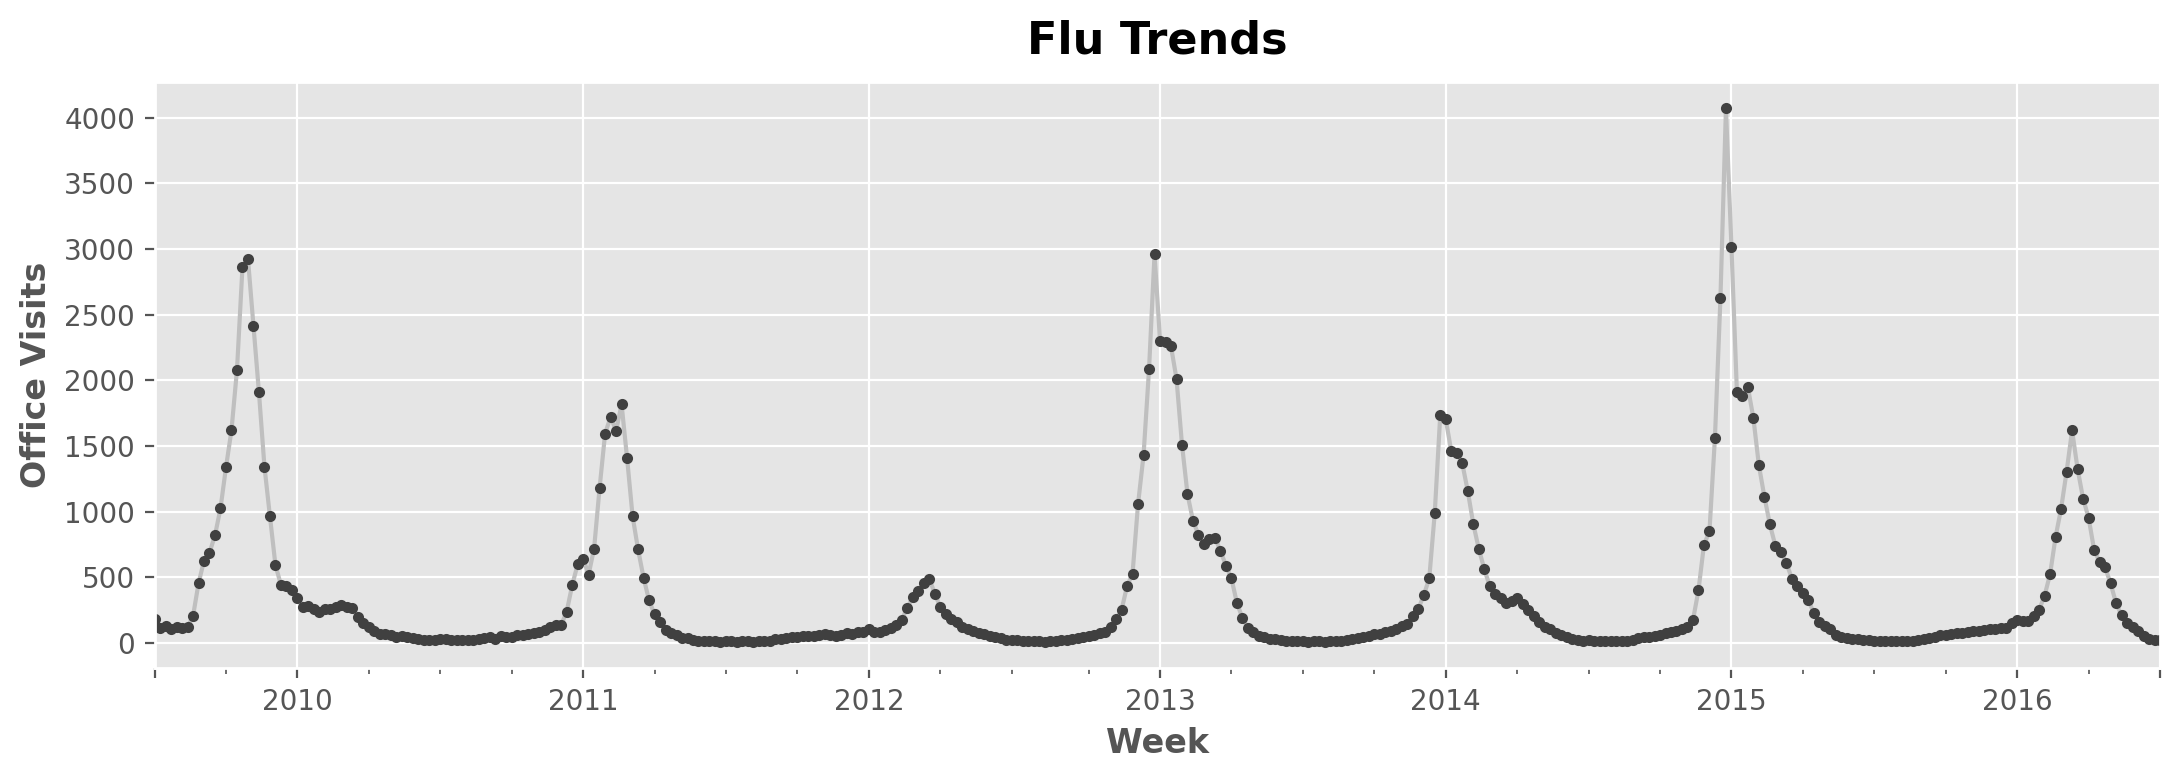

In [ ]:
flu_trends = pd.read_csv("/content/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq='W'),
    inplace=True
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title="Flu Trends", **plot_params)
_ = ax.set(ylabel="Office Visits")

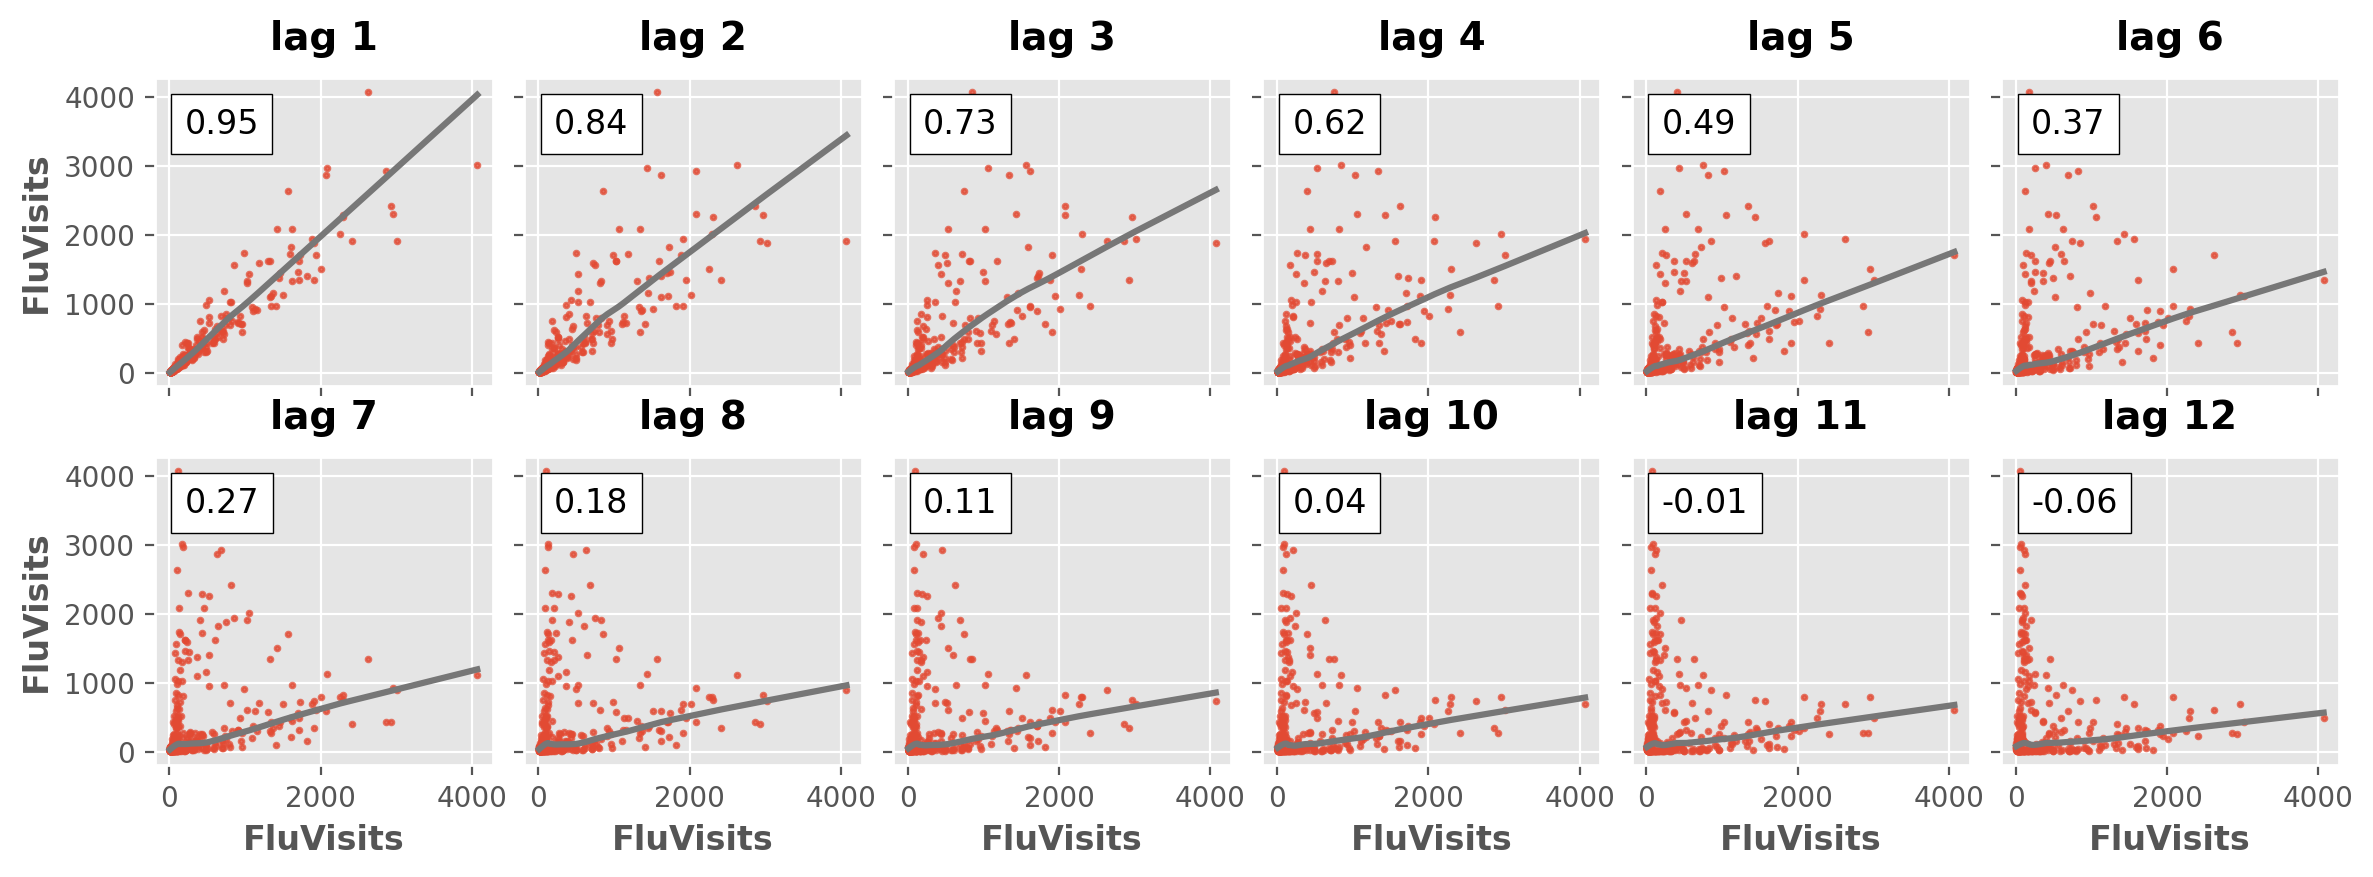

In [ ]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
#_ = plot_pacf(flu_trends.FluVisits, lags=12)

In [ ]:
def make_lags(ts, lags):
  return pd.concat(
      {
          f'y_lag_{i}' : ts.shift(i)
          for i in range(1, lags + 1)
      },
      axis=1
  )

X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [ ]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

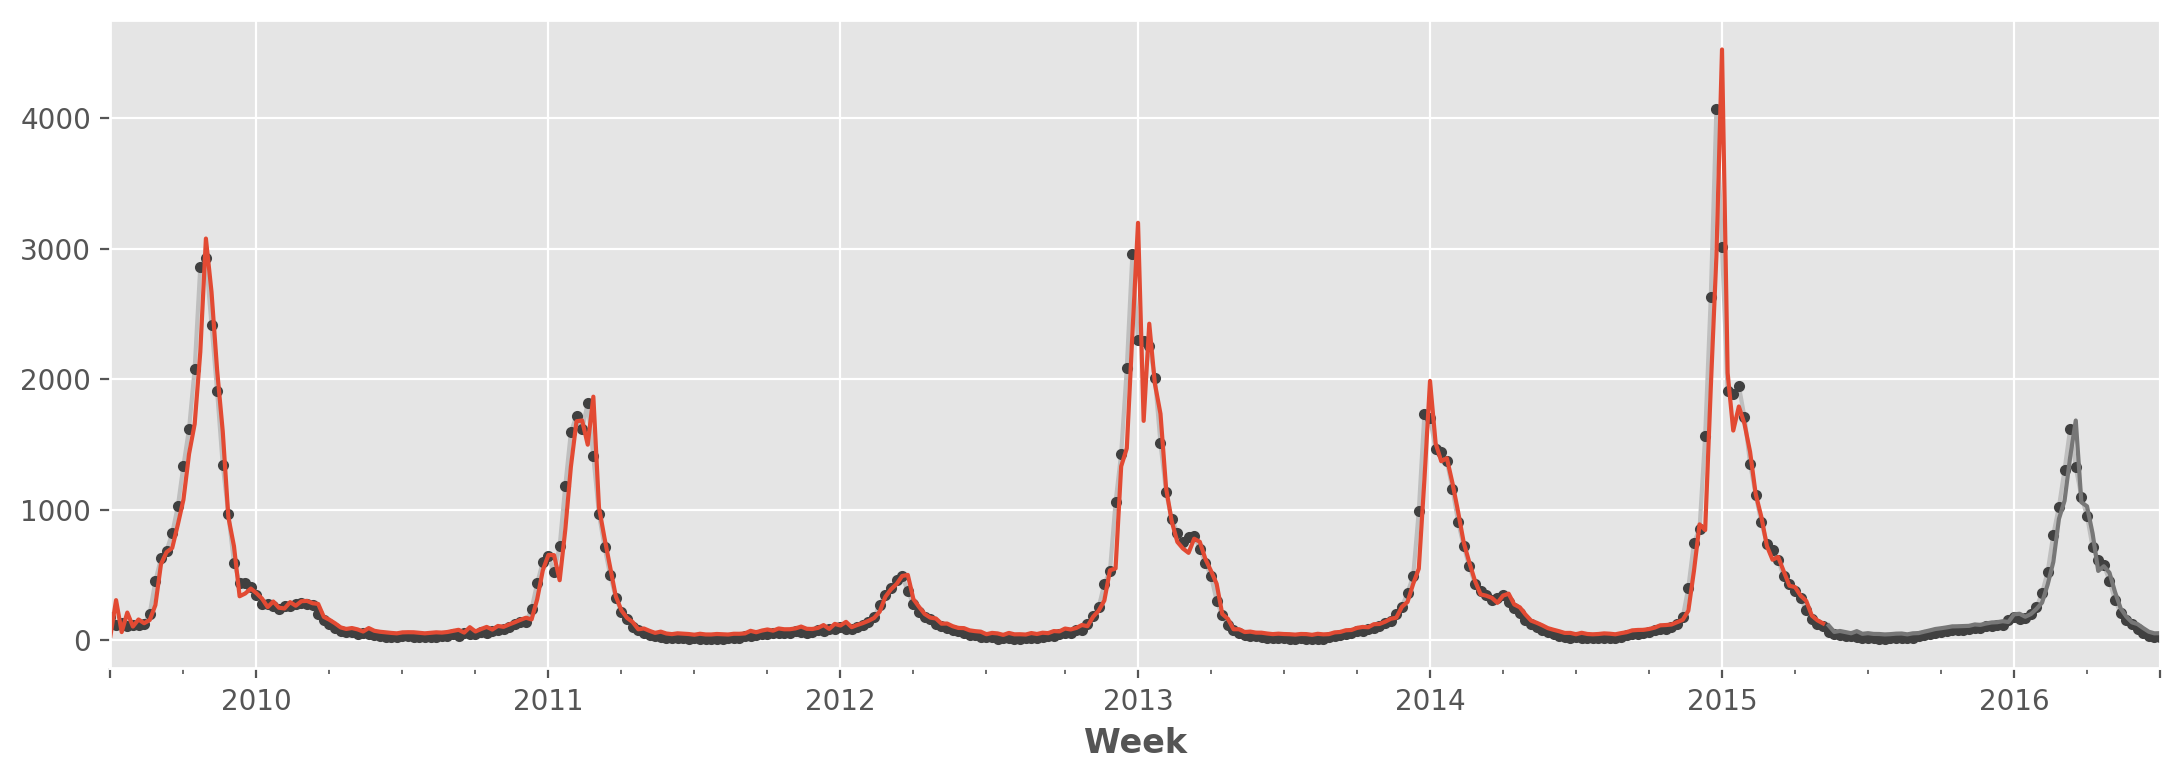

In [ ]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

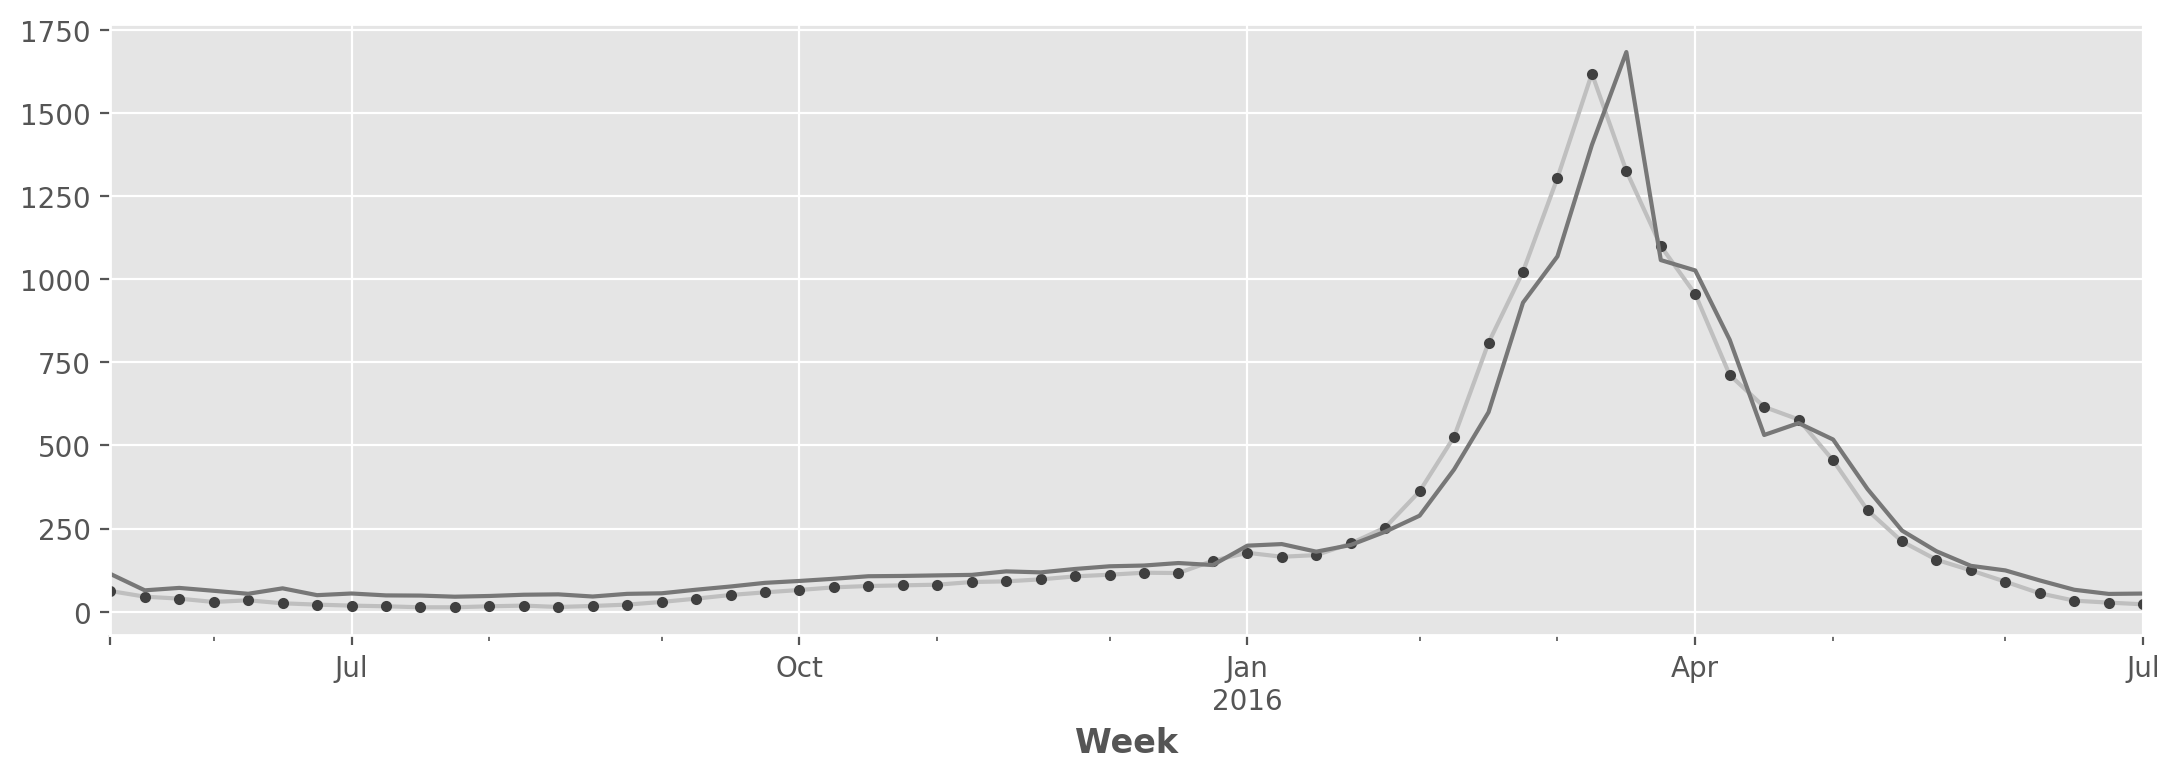

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

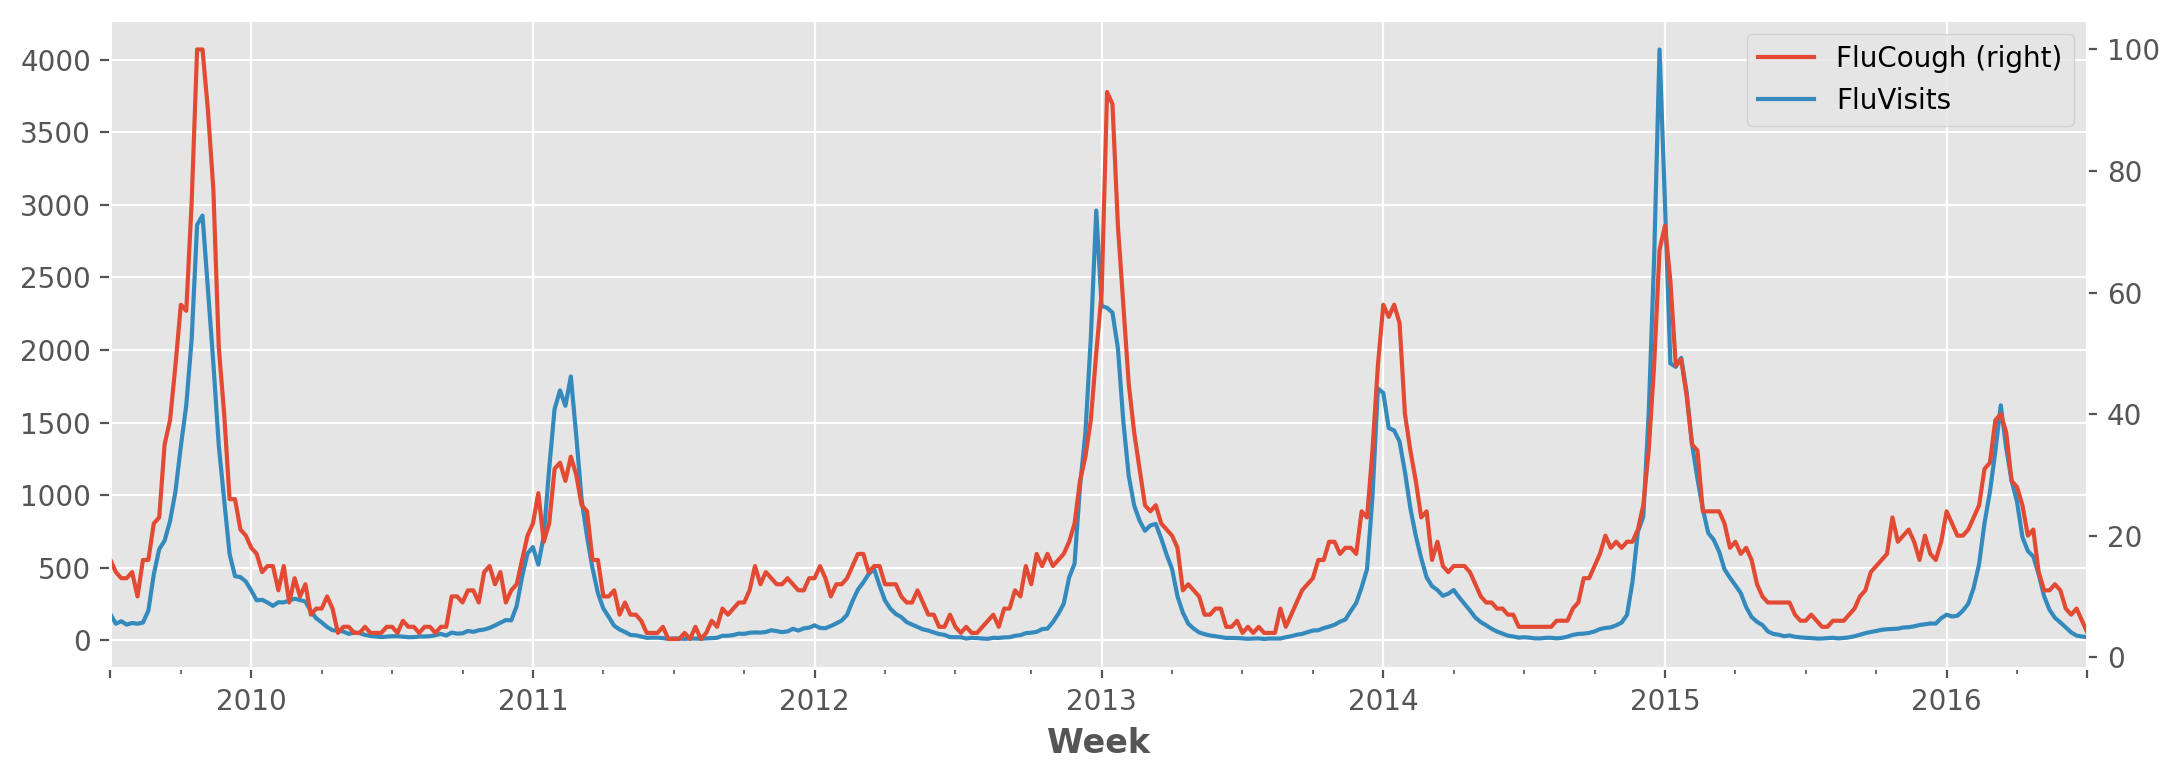

In [ ]:
ax = flu_trends.plot(
    y = ["FluCough", "FluVisits"],
    secondary_y = "FluCough"
)

In [ ]:
search_terms = ["FluContagious", "FluFever", "FluCough", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search item
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

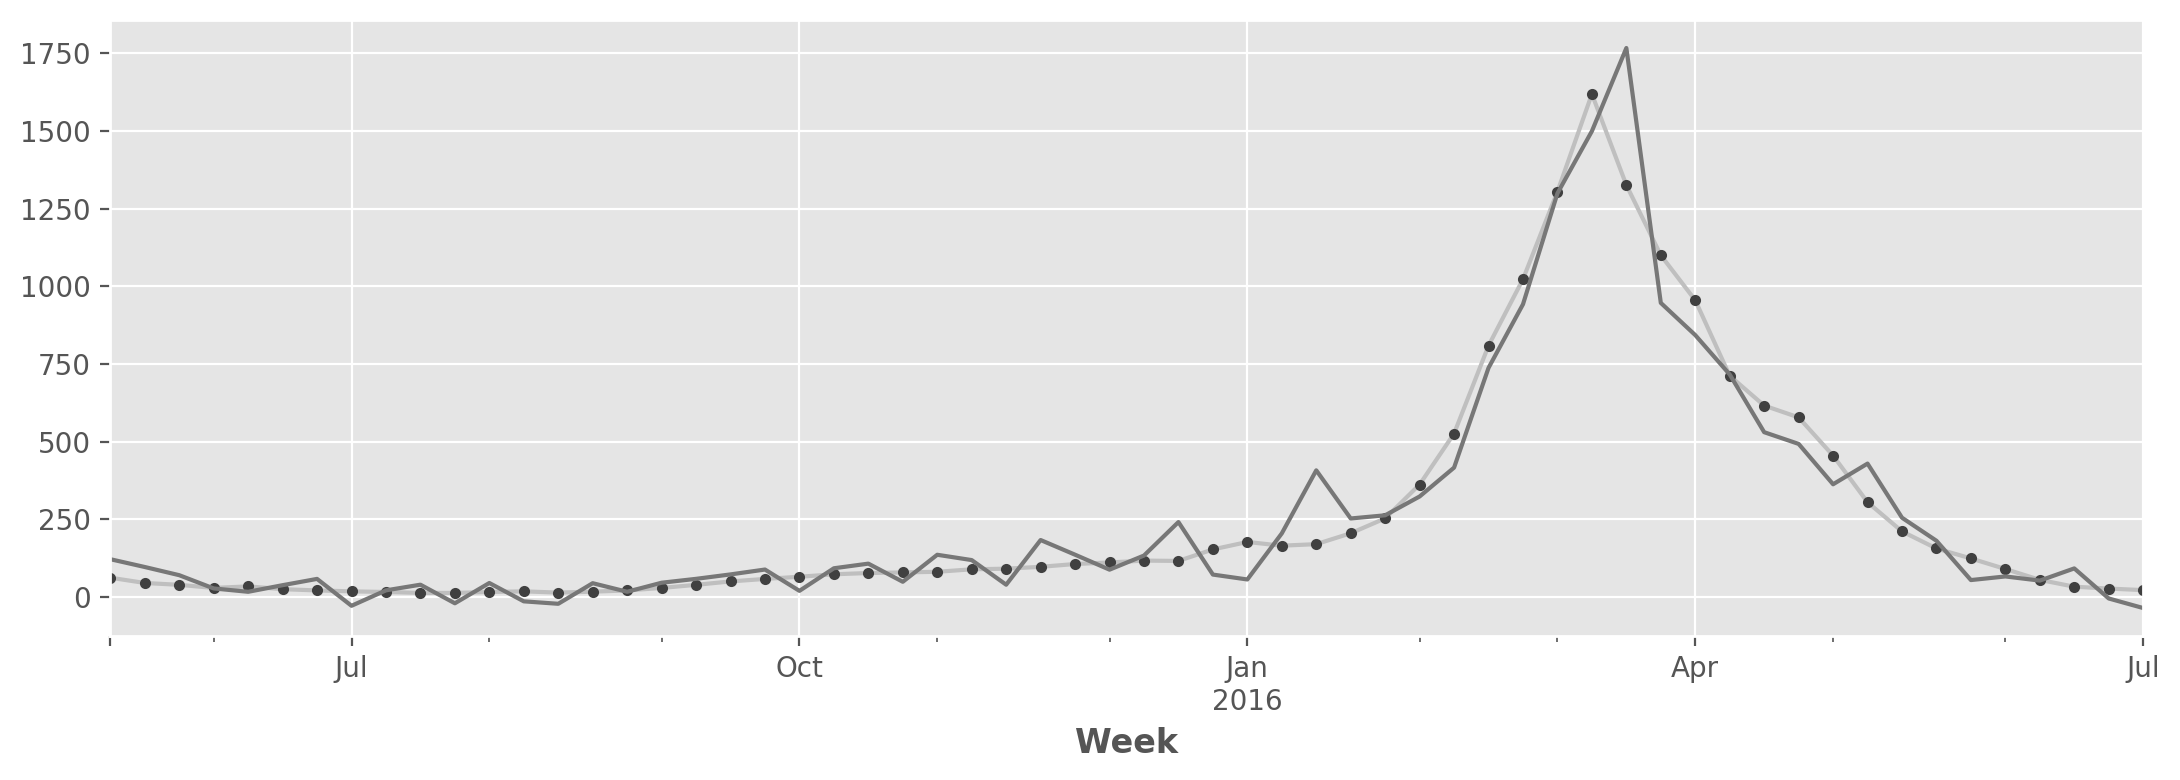

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

When we used models without lags before (maybe like linear regression, ARIMA, or Prophet), we could forecast far into the future — as many steps as we wanted — because the model used only the known patterns (like trend and seasonality) without depending directly on previous real values.

But now, when we use lag features (e.g., "Lag 1" = value from yesterday, "Lag 2" = value from 2 days ago), we rely on past observed data to make predictions.
Problem:

Suppose today is Monday.

We have a model that uses the Lag 1 feature (yesterday's value) to make a prediction.

On Monday, the Lag 1 value is Sunday's value (which we know), so we can predict Monday's value.

But if we try to predict for Wednesday, we need the value from Tuesday as the Lag 1 input.

Tuesday hasn't happened yet! So we don’t have Tuesday’s real value to use.

Thus, we're stuck — with lag features, we can't "skip ahead" easily.
We can only predict one step at a time unless we use a workaround.

In Lesson 6, they'll teach strategies to solve this — like:

Predict Tuesday first, then use that predicted value as the input for predicting Wednesday.

Or use more complex techniques like recursive forecasting.

For now, in this example, they are avoiding the complication:
They simply use the real values from a test set (future data that’s already known) to feed the model, instead of worrying about missing lags.